In [8]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import torch
import os
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

from cdvae.pl_data.dataset import CrystDataset
from cdvae.common.data_utils import get_scaler_from_data_list
from scripts.eval_utils import load_model

/home/tsaidi/envs/cdvae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsaidi/Research/cdvae_xrd/cdvae/pl_data/dataset.py:283: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")
/home/tsaidi/Research/cdvae_xrd/cdvae/pl_data/datamodule.py:142: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


In [9]:
path='/home/tsaidi/Research/cdvae_xrd/hydra/singlerun/2024-03-27/mp_20_sinc_filt_gauss_filt_nanomaterial_size_50'

model, data_loader, cfg = load_model(
    Path(path), load_data=True, batch_size=1)

/home/tsaidi/Research/cdvae_xrd/scripts/eval_utils.py:56: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(str(model_path)):
/home/tsaidi/envs/cdvae/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)
/home/tsaidi/Research/cdvae_xrd/cdvae/pl_modules/model.py:646: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


AAAAA
{'_target_': 'cdvae.pl_data.datamodule.CrystDataModule', 'datasets': {'train': {'_target_': 'cdvae.pl_data.dataset.CrystDataset', 'name': 'Formation energy train', 'path': '${data.root_path}/train.csv', 'prop': '${data.prop}', 'niggli': '${data.niggli}', 'primitive': '${data.primitive}', 'graph_method': '${data.graph_method}', 'xrd_filter': '${data.xrd_filter}', 'lattice_scale_method': '${data.lattice_scale_method}', 'preprocess_workers': '${data.preprocess_workers}', 'nanomaterial_size_angstrom': '${data.nanomaterial_size_angstrom}', 'n_presubsample': '${data.n_presubsample}', 'n_postsubsample': '${data.n_postsubsample}', 'wavesource': '${data.wavesource}'}, 'val': [{'_target_': 'cdvae.pl_data.dataset.CrystDataset', 'name': 'Formation energy val', 'path': '${data.root_path}/val.csv', 'prop': '${data.prop}', 'niggli': '${data.niggli}', 'primitive': '${data.primitive}', 'graph_method': '${data.graph_method}', 'xrd_filter': '${data.xrd_filter}', 'lattice_scale_method': '${data.latt

  0%|          | 0/1130 [00:00<?, ?it/s]/home/tsaidi/envs/cdvae/lib/python3.9/site-packages/pymatgen/io/cif.py:1150: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/tsaidi/envs/cdvae/lib/python3.9/site-packages/pymatgen/io/cif.py:1150: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/tsaidi/envs/cdvae/lib/python3.9/site-packages/pymatgen/io/cif.py:1150: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
  0%|          | 1/1130 [00:00<03:33,  5.29it/s]

In [53]:
import numpy as np
min_2_theta = 0
max_2_theta = 180
wavelength = 1.5418
nanomaterial_size = 50


min_theta = min_2_theta / 2
max_theta = max_2_theta / 2
Q_min = 4 * np.pi * np.sin(np.radians(min_theta)) / wavelength
Q_max = 4 * np.pi * np.sin(np.radians(max_theta)) / wavelength

# phase shift for sinc filter = half of the signed Q range
phase_shift = (Q_max - Q_min) / 2
Qs = np.linspace(Q_min, Q_max, 4096)
Qs_shifted = Qs - phase_shift   
sinc_filter = np.sinc(nanomaterial_size / 2 * Qs_shifted)


In [96]:
def plot_filter(Q_max, Q_min, nanomaterial_size, resolution=1000):
    Qs = np.linspace(Q_min, Q_max, int(resolution))
    _, ax = plt.subplots()
    filter = nanomaterial_size * np.sinc((np.pi * nanomaterial_size * Qs)/np.pi)
    # plot filter
    ax.plot(Qs, filter)
    ax.set_xlabel(r'Q $({A^{\circ}}^{-1})$')
    ax.set_ylabel('Filter value')
    ax.grid(True)  # Show gridlines
    plt.tight_layout()

    # plot filter in spatial domain
    # inverse shift the signal and fourier transform to freq domain
    F = np.fft.ifft(np.fft.fftshift(filter))
    # shift the signal back in freq domain
    F_shifted = np.fft.ifftshift(F)
    # calculate frequency bins
    d = -(resolution - 1) / (2 * resolution * Q_min)

    spatial_bins = d * np.arange(resolution)
    spatial_bins_shifted = spatial_bins - d * resolution / 2
    # scale and plot
    _, ax = plt.subplots()
    ax.plot(spatial_bins_shifted, np.real(F_shifted))
    ax.set_xlim(-100, 100)
    ax.set_xlabel(r'Spatial $(A^{\circ})$')
    ax.set_ylabel('Amplitude')
 
    # ax.set_xticks(np.arange(-5, 5, 1))
    # ax.set_xticklabels(ax.get_xticks(), rotation=70)  # Rotate x-axis labels by 70 degrees
    # ax.set_yticks(np.arange(-0.01, 0.05, 0.01))  # Set horizontal gridlines every 0.1 from 0 to 1
    ax.grid(True)  # Show gridlines
    plt.tight_layout()

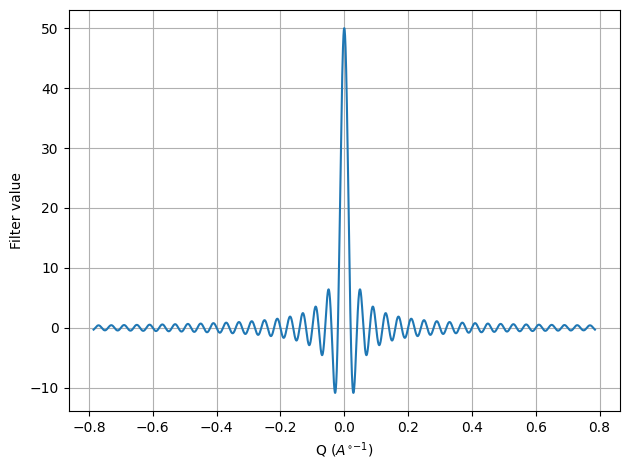

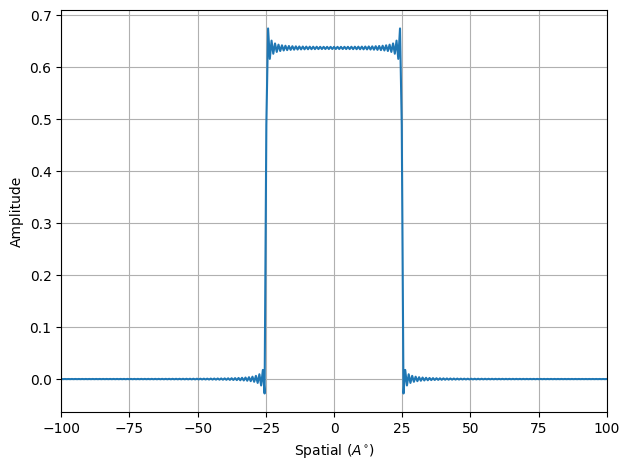

In [97]:
plot_filter(np.pi/4, -np.pi/4, 50, resolution=4096)